In this file we import some pitching data from Statcast and add a few additional columns, primarily running averages, to improve ML modeling.

In [1]:
import pybaseball as pyb
from time import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

In [2]:
a = time() # you can uncomment 2023 and 2024 if you want
#df_2023 = pyb.statcast(start_dt='2023-03-30', end_dt='2023-09-29')
#df_2024 = pyb.statcast(start_dt='2024-03-30', end_dt='2024-09-29')
df_2025 = pyb.statcast(start_dt='2025-03-30', end_dt='2025-09-29')
print(time() - a)

This is a large query, it may take a moment to complete


C:\Users\owenc\anaconda3\Lib\site-packages\pybaseball\statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
  0%|          | 0/184 [00:00<?, ?it/s]C:\Users\owenc\anaconda3\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = d

398.51291251182556


In [3]:
#df_2023 = df_2023.iloc[::-1]
#df_2024 = df_2024.iloc[::-1]
df_2025 = df_2025.iloc[::-1]

In [4]:
df = df_2025

In [5]:
first_pitch_per_pitcher = df.groupby(['game_pk', 'pitcher']).head(1)

# Step 2: Starters are those whose first pitch came in inning 1 (top or bottom)
# Warning, this line really takes anyone whose first pitch was in 1st inning and calls them a starter
# So if a starter has a meltdown and a reliever comes in in the 1st, this is still labeling the reliever a starter
starters = first_pitch_per_pitcher[first_pitch_per_pitcher['inning'] == 1]

# Step 3: Create starter ID pairs (game_pk, pitcher)
starter_ids = starters[['game_pk', 'pitcher']].drop_duplicates()

# Step 4: Label each row in the full DataFrame as 'starter' or 'reliever'
df = df.copy()  # avoid SettingWithCopyWarning

is_starter = pd.MultiIndex.from_frame(df[['game_pk','pitcher']]).isin(
    pd.MultiIndex.from_frame(starter_ids)
)
df['role'] = np.where(is_starter, 'starter', 'reliever')


In [6]:
df

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches,role
3489,FF,2025-03-30,90.8,-1.35,6.74,"Wacha, Michael",680757,608379,NaN,ball,...,1.01,0.5,-0.5,53.6,<NA>,<NA>,<NA>,<NA>,<NA>,starter
3374,CH,2025-03-30,80.0,-1.56,6.8,"Wacha, Michael",680757,608379,NaN,ball,...,2.37,1.19,-1.19,53.3,<NA>,<NA>,<NA>,<NA>,<NA>,starter
3270,FF,2025-03-30,91.2,-1.52,6.7,"Wacha, Michael",680757,608379,NaN,called_strike,...,1.16,0.61,-0.61,51.1,<NA>,<NA>,<NA>,<NA>,<NA>,starter
3154,FF,2025-03-30,92.2,-1.45,6.64,"Wacha, Michael",680757,608379,NaN,called_strike,...,1.07,0.72,-0.72,49.7,<NA>,<NA>,<NA>,<NA>,<NA>,starter
3086,CH,2025-03-30,81.0,-1.39,6.69,"Wacha, Michael",680757,608379,single,hit_into_play,...,2.51,1.11,-1.11,52.7,7.929151,-13.522106,50.545652,26.249933,27.690894,starter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364,SL,2025-09-28,85.3,-2.26,4.85,"Weissert, Greg",668670,669711,NaN,called_strike,...,2.71,-0.52,-0.52,15.8,<NA>,<NA>,<NA>,<NA>,<NA>,reliever
2261,SL,2025-09-28,84.8,-2.33,4.72,"Weissert, Greg",668670,669711,NaN,swinging_strike,...,2.55,-0.32,-0.32,12.3,13.78541,4.08139,32.414181,38.011685,27.083341,reliever
2185,FF,2025-09-28,95.4,-1.99,5.22,"Weissert, Greg",668670,669711,NaN,foul,...,1.36,0.85,0.85,22.9,2.871131,31.805044,22.266527,37.478847,15.582717,reliever
2090,FF,2025-09-28,95.1,-1.91,5.1,"Weissert, Greg",668670,669711,strikeout,called_strike,...,1.59,0.93,0.93,20.5,<NA>,<NA>,<NA>,<NA>,<NA>,reliever


In [7]:
list(df.columns) # this is a list of all the attributes... 90 percent of which are unnecessary for this project.

['pitch_type',
 'game_date',
 'release_speed',
 'release_pos_x',
 'release_pos_z',
 'player_name',
 'batter',
 'pitcher',
 'events',
 'description',
 'spin_dir',
 'spin_rate_deprecated',
 'break_angle_deprecated',
 'break_length_deprecated',
 'zone',
 'des',
 'game_type',
 'stand',
 'p_throws',
 'home_team',
 'away_team',
 'type',
 'hit_location',
 'bb_type',
 'balls',
 'strikes',
 'game_year',
 'pfx_x',
 'pfx_z',
 'plate_x',
 'plate_z',
 'on_3b',
 'on_2b',
 'on_1b',
 'outs_when_up',
 'inning',
 'inning_topbot',
 'hc_x',
 'hc_y',
 'tfs_deprecated',
 'tfs_zulu_deprecated',
 'umpire',
 'sv_id',
 'vx0',
 'vy0',
 'vz0',
 'ax',
 'ay',
 'az',
 'sz_top',
 'sz_bot',
 'hit_distance_sc',
 'launch_speed',
 'launch_angle',
 'effective_speed',
 'release_spin_rate',
 'release_extension',
 'game_pk',
 'fielder_2',
 'fielder_3',
 'fielder_4',
 'fielder_5',
 'fielder_6',
 'fielder_7',
 'fielder_8',
 'fielder_9',
 'release_pos_y',
 'estimated_ba_using_speedangle',
 'estimated_woba_using_speedangle',
 'w

In [8]:
df['pitch_count'] = df.groupby(['game_pk', 'pitcher']).cumcount() + 1

In [10]:
import time

below is the key function I have added. It analyzes a single pitcher's data back a customizable number of pitches, analyzes some running averages, and implements RE288 for him alone.

In [86]:
def analyze(pname, extent=100): 
    # What this does is it adds a "running average" for a few stats to the dataframe for a specific pitcher across 2025...
    # ... and then find that specific pitcher's RE288 (expected runs given BSO123) average.
    pitcher = pyb.playerid_lookup(pname)['key_mlbam'][0]
    # this, for a single pitcher, gives a running average of certain datapoints over a certain number of pitches in the past
    d = df[df['pitcher']==pitcher] #only this pitcher
    print("Testing...", pname)
    time.sleep(2.0) # adds a little suspense, you can comment these out
    dr = d
    dr['item']=np.array(range(len(d)))
    # the indices are weird, this keeps it as 0 through n-1
    # Use existing data to calculate each individual pitcher's RE288
    extent = min(extent, len(dr)) # don't go beyond the number of pitches he actually threw!
    print("Extent = ",extent)
    time.sleep(2.0)
    def rsiti(game, inning, t, curr): #runs scored in this inning, or until the pitcher is yanked.
        u = {0: "Top", 1:"Bot"}
        thisinning = dr[(dr['game_pk']==game) & (dr['inning']==inning) & (dr['inning_topbot']==u[t])] #restricts to an individual inning and pitcher
        return max(thisinning['bat_score']-curr) #how many more runs?
    time.sleep(2.0)
    
    print("Adding the remaining runs datapoint.")
    dr['remaining_runs']=dr.apply(lambda x: rsiti(x.game_pk, x.inning, int(x.inning_topbot=='Bot'), x.bat_score), axis=1) #turns this into a dataframe column
    time.sleep(2.0)
    print("Adding the RE288 datapoint.")
    time.sleep(2.0)
    dr['re288case']=dr.apply(lambda x: 252 - 144 * pd.isna(x['on_3b']) - 72 * pd.isna(x['on_2b']) - 36 * pd.isna(x['on_1b']) + 3*x['balls']+x['strikes']+12*x['outs_when_up'], axis=1
                            ) # turns the BSO123 instance into a number from 0 to 287.
    print("Moving on.")
    time.sleep(2.0)
    re288={i:0 for i in range(288)} # these dicts will calculate the pitcher's personal re288 value
    re288counts={i:0 for i in range(288)}
    running_outs = np.zeros(len(dr)) # running total of outs
    running_7plus = np.zeros(len(dr)) # running total of long at bats (7 or more pitches, assumes no mid-PA pitching changes)
    running_risp = np.zeros(len(dr)) # running total of pitches thrown with runner(s) in scoring position
    running_restarts = np.zeros(len(dr)) # running total of games pitched in 
    scale = np.concatenate((np.array(range( 1, extent+1)), extent*np.ones(len(dr)-extent).astype(int))) # scales the running totals, turns them into averages
    for i in range(len(dr)):
        if i%100==0:
            print(i, "pitches covered...")
            time.sleep(1.0)
        
        drl = dr.loc[dr['item']==i].iloc[0]
        
        if i==0:
            running_outs[i]=0
            running_7plus[i]=0
            running_risp[i]=1-int(pd.isna(drl['on_2b']) & pd.isna(drl['on_3b']))
            running_restarts[i]=int(drl['pitch_count']==1)
            re288counts[int(drl['re288case'])]+=1
            re288[int(drl['re288case'])]+=int(drl['remaining_runs'])
            
        elif i < extent:
            
            running_outs[i]=running_outs[i-1]+(drl['outs_when_up']-dr.loc[dr['item']==i-1].iloc[0]['outs_when_up'])%3 # add 1 if an out occurred
            running_7plus[i]=running_7plus[i-1]+(drl['pitch_number']==7) # 7th pitch of at bat = trigger
            running_risp[i]=running_risp[i-1]+1-(pd.isna(drl['on_2b']) & pd.isna(drl['on_3b']))
            running_restarts[i]=running_restarts[i-1]+(drl['pitch_count']==1) # pitch count of 1 is the trigger
            re288counts[int(drl['re288case'])]+=1
            re288[int(drl['re288case'])]+=int(drl['remaining_runs'])
            
        else:
            if i==extent: # throughout this, take out the "extent"th entry from the end (as that is the max length)
                merp = 0 # prevents indexing errors
            else:
                merp = (dr.loc[dr['item']==i-extent]['outs_when_up']-dr.loc[dr['item']==i-extent-1].iloc[0]['outs_when_up'])%3
            drlx = dr.loc[dr['item']==i-extent].iloc[0]
            running_outs[i]=running_outs[i-1]+(drl['outs_when_up']-dr.loc[dr['item']==i-1].iloc[0]['outs_when_up'])%3-merp
            running_7plus[i]=running_7plus[i-1]+(drl['pitch_number']==7)-(drlx['pitch_number']==7)
            running_risp[i]=running_risp[i-1]-(pd.isna(drl['on_2b']) & pd.isna(drl['on_3b']))+(pd.isna(drlx['on_2b']) & pd.isna(drlx['on_3b']))
            running_restarts[i]=running_restarts[i-1]+(drl['pitch_count']==1)-(drlx['pitch_count']==1)
            re288counts[int(drl['re288case'])]+=1
            re288[int(drl['re288case'])]+=(drl['remaining_runs'])
            
    print("Completed.")
    time.sleep(2.0)
    dr['ro']=running_outs / scale # this "scale"makes everything a running average -- since it goes 1, 2, 3, ... up to "extent" and then stays there
    dr['r7']=running_7plus / scale
    dr['rs']=running_risp / scale
    dr['rr']=running_restarts / scale # four new columns added to dataframe
    re288avgs={}
    for i in range(288):
        if re288counts[i]==0:
            re288avgs[i]= float("nan") # so we don't divide by zero
        else:
            re288avgs[i] = re288[i]/re288counts[i] # actual re288 averages
    print("Returning values...")
    time.sleep(2.0)
    dr['re288_expected_runs']=dr. apply(lambda x: re288avgs[int(x['re288case'])], axis=1)
    return dr, re288avgs
    

In [137]:
a_skenes=analyze("Skenes", 100)
# Paul Skenes, Cy Young Frontrunner for the Pirates. With a 2025 era of 1.97 he has unusually low RE288 values.

Testing... Skenes


C:\Users\owenc\AppData\Local\Temp\ipykernel_23212\3068334452.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr['item']=np.array(range(len(d)))


Extent =  100
Adding the remaining runs datapoint.


C:\Users\owenc\AppData\Local\Temp\ipykernel_23212\3068334452.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr['remaining_runs']=dr.apply(lambda x: rsiti(x.game_pk, x.inning, int(x.inning_topbot=='Bot'), x.bat_score), axis=1) #turns this into a dataframe column


Adding the RE288 datapoint.


C:\Users\owenc\AppData\Local\Temp\ipykernel_23212\3068334452.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr['re288case']=dr.apply(lambda x: 252 - 144 * pd.isna(x['on_3b']) - 72 * pd.isna(x['on_2b']) - 36 * pd.isna(x['on_1b']) + 3*x['balls']+x['strikes']+12*x['outs_when_up'], axis=1


Moving on.
0 pitches covered...
100 pitches covered...


C:\Users\owenc\AppData\Local\Temp\ipykernel_23212\3068334452.py:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  running_outs[i]=running_outs[i-1]+(drl['outs_when_up']-dr.loc[dr['item']==i-1].iloc[0]['outs_when_up'])%3-merp


200 pitches covered...
300 pitches covered...
400 pitches covered...
500 pitches covered...
600 pitches covered...
700 pitches covered...
800 pitches covered...
900 pitches covered...
1000 pitches covered...
1100 pitches covered...
1200 pitches covered...
1300 pitches covered...
1400 pitches covered...
1500 pitches covered...
1600 pitches covered...
1700 pitches covered...
1800 pitches covered...
1900 pitches covered...
2000 pitches covered...
2100 pitches covered...
2200 pitches covered...
2300 pitches covered...
2400 pitches covered...
2500 pitches covered...
2600 pitches covered...
2700 pitches covered...
2800 pitches covered...
2900 pitches covered...
Completed.


C:\Users\owenc\AppData\Local\Temp\ipykernel_23212\3068334452.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr['ro']=running_outs / scale # this "scale"makes everything a running average
C:\Users\owenc\AppData\Local\Temp\ipykernel_23212\3068334452.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr['r7']=running_7plus / scale
C:\Users\owenc\AppData\Local\Temp\ipykernel_23212\3068334452.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

Returning values...


C:\Users\owenc\AppData\Local\Temp\ipykernel_23212\3068334452.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr['re288_expected_runs']=dr. apply(lambda x: re288avgs[int(x['re288case'])], axis=1)


In [142]:
a_littell = analyze("Littell",100) #Zack Littell, a league-average pitcher.

Testing... Littell


C:\Users\owenc\AppData\Local\Temp\ipykernel_23212\3068334452.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr['item']=np.array(range(len(d)))


Extent =  100
Adding the remaining runs datapoint.


C:\Users\owenc\AppData\Local\Temp\ipykernel_23212\3068334452.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr['remaining_runs']=dr.apply(lambda x: rsiti(x.game_pk, x.inning, int(x.inning_topbot=='Bot'), x.bat_score), axis=1) #turns this into a dataframe column


Adding the RE288 datapoint.


C:\Users\owenc\AppData\Local\Temp\ipykernel_23212\3068334452.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr['re288case']=dr.apply(lambda x: 252 - 144 * pd.isna(x['on_3b']) - 72 * pd.isna(x['on_2b']) - 36 * pd.isna(x['on_1b']) + 3*x['balls']+x['strikes']+12*x['outs_when_up'], axis=1


Moving on.
0 pitches covered...
100 pitches covered...


C:\Users\owenc\AppData\Local\Temp\ipykernel_23212\3068334452.py:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  running_outs[i]=running_outs[i-1]+(drl['outs_when_up']-dr.loc[dr['item']==i-1].iloc[0]['outs_when_up'])%3-merp


200 pitches covered...
300 pitches covered...
400 pitches covered...
500 pitches covered...
600 pitches covered...
700 pitches covered...
800 pitches covered...
900 pitches covered...
1000 pitches covered...
1100 pitches covered...
1200 pitches covered...
1300 pitches covered...
1400 pitches covered...
1500 pitches covered...
1600 pitches covered...
1700 pitches covered...
1800 pitches covered...
1900 pitches covered...
2000 pitches covered...
2100 pitches covered...
2200 pitches covered...
2300 pitches covered...
2400 pitches covered...
2500 pitches covered...
2600 pitches covered...
2700 pitches covered...
Completed.


C:\Users\owenc\AppData\Local\Temp\ipykernel_23212\3068334452.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr['ro']=running_outs / scale # this "scale"makes everything a running average
C:\Users\owenc\AppData\Local\Temp\ipykernel_23212\3068334452.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr['r7']=running_7plus / scale
C:\Users\owenc\AppData\Local\Temp\ipykernel_23212\3068334452.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

Returning values...


C:\Users\owenc\AppData\Local\Temp\ipykernel_23212\3068334452.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr['re288_expected_runs']=dr. apply(lambda x: re288avgs[int(x['re288case'])], axis=1)


In [143]:
a_senzatela=analyze("Senzatela", 100) # Anthony Senzatela, a below-replacement-level pitcher for Colorado (Sorry!).

Testing... Senzatela


C:\Users\owenc\AppData\Local\Temp\ipykernel_23212\3068334452.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr['item']=np.array(range(len(d)))


Extent =  100
Adding the remaining runs datapoint.


C:\Users\owenc\AppData\Local\Temp\ipykernel_23212\3068334452.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr['remaining_runs']=dr.apply(lambda x: rsiti(x.game_pk, x.inning, int(x.inning_topbot=='Bot'), x.bat_score), axis=1) #turns this into a dataframe column


Adding the RE288 datapoint.


C:\Users\owenc\AppData\Local\Temp\ipykernel_23212\3068334452.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr['re288case']=dr.apply(lambda x: 252 - 144 * pd.isna(x['on_3b']) - 72 * pd.isna(x['on_2b']) - 36 * pd.isna(x['on_1b']) + 3*x['balls']+x['strikes']+12*x['outs_when_up'], axis=1


Moving on.
0 pitches covered...
100 pitches covered...


C:\Users\owenc\AppData\Local\Temp\ipykernel_23212\3068334452.py:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  running_outs[i]=running_outs[i-1]+(drl['outs_when_up']-dr.loc[dr['item']==i-1].iloc[0]['outs_when_up'])%3-merp


200 pitches covered...
300 pitches covered...
400 pitches covered...
500 pitches covered...
600 pitches covered...
700 pitches covered...
800 pitches covered...
900 pitches covered...
1000 pitches covered...
1100 pitches covered...
1200 pitches covered...
1300 pitches covered...
1400 pitches covered...
1500 pitches covered...
1600 pitches covered...
1700 pitches covered...
1800 pitches covered...
1900 pitches covered...
2000 pitches covered...
2100 pitches covered...
2200 pitches covered...
Completed.


C:\Users\owenc\AppData\Local\Temp\ipykernel_23212\3068334452.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr['ro']=running_outs / scale # this "scale"makes everything a running average
C:\Users\owenc\AppData\Local\Temp\ipykernel_23212\3068334452.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr['r7']=running_7plus / scale
C:\Users\owenc\AppData\Local\Temp\ipykernel_23212\3068334452.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

Returning values...


C:\Users\owenc\AppData\Local\Temp\ipykernel_23212\3068334452.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr['re288_expected_runs']=dr. apply(lambda x: re288avgs[int(x['re288case'])], axis=1)


Next, we convert the re288 dictionaries into dataframes.

In [144]:
skenesdf=pd.DataFrame(a_skenes[1].items(),columns=['Situation','Statistic']); senzateladf=pd.DataFrame(a_senzatela[1].items(),columns=['Situation','Statistic']); littelldf=pd.DataFrame(a_littell[1].items(),columns=['Situation','Statistic'])

In [145]:
skenesdf['id']=1

In [146]:
senzateladf['id']=3

In [147]:
littelldf['id']=2

In [148]:
combined_df = pd.concat([skenesdf,littelldf,senzateladf]) # combines everything to make a scatterplot

In [149]:
combined_df

,Situation,Statistic,id
0,0,0.235602,1
1,1,0.183673,1
2,2,0.258065,1
3,3,0.229730,1
4,4,0.181818,1
...,...,...,...
283,283,3.000000,3
284,284,NaN,3
285,285,NaN,3
286,286,NaN,3


In [150]:
combined_df['on3rd']=combined_df['Situation']//144

In [151]:
combined_df['on2nd']=(combined_df['Situation']//72)%2

In [152]:
combined_df['on1st']=(combined_df['Situation']//36)%2

In [153]:
combined_df['outs']=(combined_df['Situation']//12)%3

In [154]:
combined_df['balls']=(combined_df['Situation']//3)%4

In [155]:
combined_df['strikes']=(combined_df['Situation']//1)%3

In [156]:
combined_df

,Situation,Statistic,id,on3rd,on2nd,on1st,outs,balls,strikes
0,0,0.235602,1,0,0,0,0,0,0
1,1,0.183673,1,0,0,0,0,0,1
2,2,0.258065,1,0,0,0,0,0,2
3,3,0.229730,1,0,0,0,0,1,0
4,4,0.181818,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...
283,283,3.000000,3,1,1,1,2,2,1
284,284,NaN,3,1,1,1,2,2,2
285,285,NaN,3,1,1,1,2,3,0
286,286,NaN,3,1,1,1,2,3,1


In [112]:
skenesdf.style.background_gradient()

,Situation,Statistic,on3rd,on2nd,on1st,strikes,outs,balls
0,0,0.235602,0,0,0,0,0,0
1,1,0.183673,0,0,0,1,0,0
2,2,0.258065,0,0,0,2,0,0
3,3,0.229730,0,0,0,0,0,1
4,4,0.181818,0,0,0,1,0,1
5,5,0.157303,0,0,0,2,0,1
6,6,0.368421,0,0,0,0,0,2
7,7,0.342105,0,0,0,1,0,2
8,8,0.160494,0,0,0,2,0,2
9,9,0.333333,0,0,0,0,0,3


<Axes: xlabel='Situation', ylabel='Statistic'>

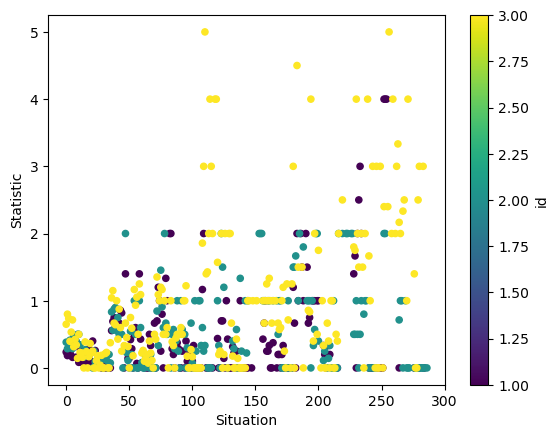

In [157]:
combined_df.plot.scatter(x='Situation',y='Statistic',c='id',colormap='viridis')

Paul Skenes's RE288 statistics are in purple. Anthony Senzatela's are in yellow. It's pretty clear who is the more effective pitcher.

The last few cells are for graphing Tom Tango's 2018 RE288 grid. It is not on the same plot because it goes until the end of the inning, whether or not the pitcher is taken out.

In [158]:
tango2018={}

In [159]:
tango000=[0.51, 0.47, 0.42, 0.55, 0.50, 0.55, 0.61, 0.55, 0.48, 0.74, 0.67, 0.59, 0.27, 0.24, 0.21, 0.30, 0.26, 0.22, 0.35, 0.30, 0.25, 0.43, 0.38, 0.32, 0.10, 0.09, 0.06, 0.12, 0.10, 0.07, 0.14, 0.12, 0.09, 0.18, 0.16, 0.12]

In [160]:
tango001 = [0.90, 0.84, 0.76, 0.96, 0.89, 0.80, 1.07, 0.98, 0.87, 1.25, 1.15, 1.03, 0.53, 0.48, 0.41, 0.57, 0.51, 0.43, 0.64, 0.57, 0.49, 0.77, 0.69, 0.60, 0.23, 0.19, 0.14, 0.26, 0.21, 0.16, 0.30, 0.24, 0.18, 0.37, 0.32, 0.25]

In [161]:
tango010=[1.15, 1.10, 0.99, 1.20, 1.13, 1.03, 1.25, 1.20, 1.09, 1.38, 1.30, 1.18, 0.69, 0.63, 0.55, 0.73, 0.67, 0.58, 0.79, 0.72, 0.63, 0.85, 0.79, 0.71, 0.32, 0.27, 0.19, 0.35, 0.31, 0.22, 0.38, 0.34, 0.26, 0.41, 0.39, 0.32]

In [162]:
tango011=[1.50, 1.41, 1.31, 1.58, 1.47, 1.34, 1.74, 1.57, 1.41, 1.98, 1.83, 1.64, 0.93, 0.86, 0.76, 1.00, 0.91, 0.80, 1.10, 1.00, 0.86, 1.33, 1.21, 1.06, 0.44, 0.38, 0.26, 0.49, 0.41, 0.31, 0.57, 0.49, 0.38, 0.68, 0.61, 0.49]

In [163]:
tango100=[1.38, 1.33, 1.23, 1.44, 1.37, 1.26, 1.48, 1.41, 1.34, 1.60, 1.52, 1.43, 0.93, 0.86, 0.76, 1.00, 0.91, 0.80, 1.05, 0.99, 0.86, 1.13, 1.06, 0.95, 0.36, 0.32, 0.23, 0.39, 0.34, 0.26, 0.43, 0.38, 0.31, 0.49, 0.45, 0.37]

In [175]:
tango101 = [1.78, 1.68, 1.56, 1.85, 1.74, 1.60, 1.91, 1.82, 1.67, 2.08, 1.98, 1.86, 1.21, 1.13, 0.98, 1.24, 1.18, 1.03, 1.33, 1.25, 1.09, 1.44, 1.36, 1.24, 0.50, 0.42, 0.31, 0.55, 0.47, 0.37, 0.63, 0.54, 0.44, 0.73, 0.67, 0.54]

In [165]:
tango110=[1.98, 1.91, 1.77, 2.03, 1.95, 1.81, 2.09, 1.99, 1.85, 2.19, 2.11, 1.97, 1.37, 1.28, 1.10, 1.42, 1.32, 1.17, 1.48, 1.39, 1.22, 1.54, 1.48, 1.33, 0.57, 0.48, 0.35, 0.62, 0.53, 0.39, 0.68, 0.57, 0.44, 0.75, 0.69, 0.54]

In [166]:
tango111=[2.32, 2.21, 2.08, 2.40, 2.27, 2.09, 2.52, 2.46, 2.26, 2.89, 2.63, 2.58, 1.57, 1.43, 1.27, 1.68, 1.53, 1.34, 1.82, 1.68, 1.46, 2.15, 1.91, 1.78, 0.76, 0.62, 0.46, 0.90, 0.74, 0.54, 1.05, 0.89, 0.67, 1.38, 1.18, 0.92]

In [177]:
tango = tango000+tango001+tango010+tango011+tango100+tango101+tango110+tango111

In [178]:
test = { i: tango[i] for i in range(288)}

In [179]:
test

{0: 0.51,
 1: 0.47,
 2: 0.42,
 3: 0.55,
 4: 0.5,
 5: 0.55,
 6: 0.61,
 7: 0.55,
 8: 0.48,
 9: 0.74,
 10: 0.67,
 11: 0.59,
 12: 0.27,
 13: 0.24,
 14: 0.21,
 15: 0.3,
 16: 0.26,
 17: 0.22,
 18: 0.35,
 19: 0.3,
 20: 0.25,
 21: 0.43,
 22: 0.38,
 23: 0.32,
 24: 0.1,
 25: 0.09,
 26: 0.06,
 27: 0.12,
 28: 0.1,
 29: 0.07,
 30: 0.14,
 31: 0.12,
 32: 0.09,
 33: 0.18,
 34: 0.16,
 35: 0.12,
 36: 0.9,
 37: 0.84,
 38: 0.76,
 39: 0.96,
 40: 0.89,
 41: 0.8,
 42: 1.07,
 43: 0.98,
 44: 0.87,
 45: 1.25,
 46: 1.15,
 47: 1.03,
 48: 0.53,
 49: 0.48,
 50: 0.41,
 51: 0.57,
 52: 0.51,
 53: 0.43,
 54: 0.64,
 55: 0.57,
 56: 0.49,
 57: 0.77,
 58: 0.69,
 59: 0.6,
 60: 0.23,
 61: 0.19,
 62: 0.14,
 63: 0.26,
 64: 0.21,
 65: 0.16,
 66: 0.3,
 67: 0.24,
 68: 0.18,
 69: 0.37,
 70: 0.32,
 71: 0.25,
 72: 1.15,
 73: 1.1,
 74: 0.99,
 75: 1.2,
 76: 1.13,
 77: 1.03,
 78: 1.25,
 79: 1.2,
 80: 1.09,
 81: 1.38,
 82: 1.3,
 83: 1.18,
 84: 0.69,
 85: 0.63,
 86: 0.55,
 87: 0.73,
 88: 0.67,
 89: 0.58,
 90: 0.79,
 91: 0.72,
 92: 0.63,


In [180]:
testdf=pd.DataFrame(test.items(),columns=['Situation','Statistic'])

In [181]:
testdf['id']=0

<Axes: xlabel='Situation', ylabel='Statistic'>

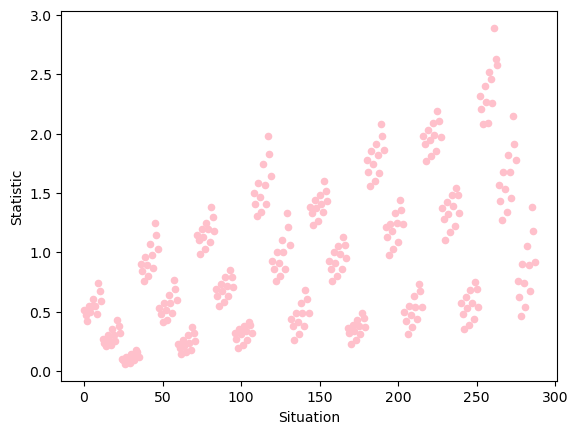

In [194]:
testdf.plot.scatter(x='Situation',y='Statistic', c="pink")

The new features (running average and re288) are key components of the model.